In [61]:
# import diffeq_2 as methods
from scipy.integrate import odeint
import pydub
import time
from tqdm import tqdm
import math
from scipy import special, interpolate

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
sns.set_theme()


In [39]:
def delta(x, y):
    return 1 if x == y else 0


def Aij(m, n, m_, n_):
    return -np.pi/2 * delta(m, m_) * (n*n_*(3+4*m))/(2+4*m+n+n_)*special.beta(n+n_-1, 3+4*m)


def bi(m_, n_):
    return -2/(2*m_+1)*special.beta(2*m_+3, n_+1)


def psi_ij(xi, fi, m, n):
    return xi**(2*m+1) * (1-xi)**n * np.sin((2*m+1)*fi)


## Matrika A in vektor b

Najprej naloga zahtevan, da izračunamo bločne matrike, ki sestavljajo matriko A ter vektor b. Za lepšo predstavo (enako kot v navodilih) sem matriko A tudi narisal.

Ni potrebno iskati inverza matrike A, lahko zgolj rešimo sistem enačb z \texttt{scipy.linalg.solve}.
Matrika je očitno bločno diagonalna (bloki po diagonali), kar je v skladu s pričakovanji.

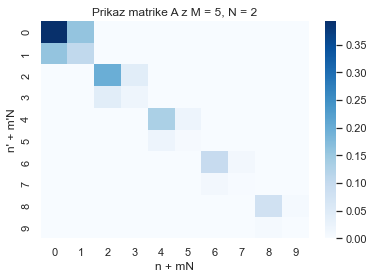

In [216]:
def A_and_b(M,N):
    M, N = np.int32(M), np.int32(N)

    A = np.zeros((N*M, N*M))
    b = np.zeros(N*M)

    for m in range(M):
        for n in range(N):
            for n_ in range(N):
                A[m*N+n, m*N+n_] = Aij(m, n + 1, m, n_ + 1)
            b[m*N+n] = bi(m, n + 1)

    return A, b

A,b = A_and_b(5,2)

sns.heatmap(np.abs(A), cmap='Blues')
plt.xlabel('n + mN')
plt.ylabel('n\' + m\'N')
plt.title("Prikaz matrike A z M = 5, N = 2")

plt.savefig("./grafi/A_5_2.pdf", bbox_inches='tight')
# A x = b


## Napaka po M, N

Natančnost Cja je zelo velika že pri zelo majhnih vrednostih M in N. To pomeni, da je metoda precej numerično učinkovita, saj se že pri vrednostih M,N = 1, napaka manjša od 10\%.

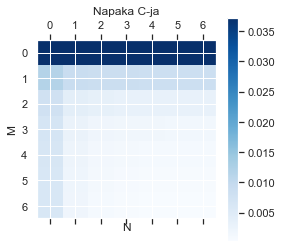

In [217]:
def C_nm(M, N):
    M,N = np.int32(M), np.int32(N)
    A, b = A_and_b(M, N)
    xx = np.linalg.solve(A, b)
    return -32/np.pi * np.dot(b, xx)

M, N = 7,7

Cij = np.zeros((M, N))
for m in range(M):
    for n in range(N):
        Cij[m, n] = C_nm(m+1, n+1)

# Cij = np.fromfunction(lambda m,n: C_nm(n+1,m+1), (5,5))


C_ref = 0.7577220257467273

plt.matshow(C_ref - Cij, cmap='Blues')
plt.colorbar()

plt.xlabel('N')
plt.ylabel('M')
plt.title("Napaka C-ja")
plt.savefig("./grafi/napaka_c.pdf", bbox_inches='tight')

plt.show()

In [215]:
M, N = 100,100
A, b = A_and_b(M, N)

xx = np.linalg.solve(A, b)
C = -32/np.pi * np.dot(b, xx)

C

0.7577218670524574

Če sedaj pošljemo M in N v limito (100, 100), dobimo, da je teoretična napoved C 0.75772186..., kar je več kot dovolj natančno (pridemo, do numerične limite, lahko pa bi seveda šli poljubno natančno s paketom Decimal).

90000 90000


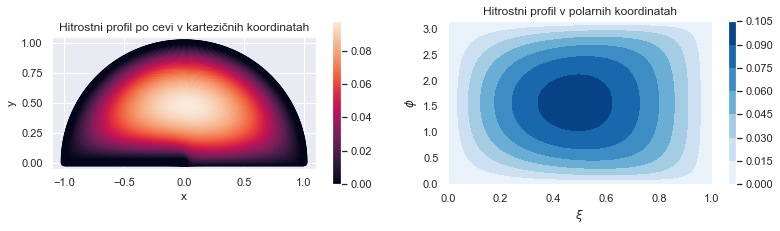

In [218]:
M, N = 30, 30
A, b = A_and_b(M, N)

xx = np.linalg.solve(A, b)

xis = np.linspace(0, 1, 300)
fis = np.linspace(0, np.pi, 300)
psis = np.zeros((len(xis), len(fis)))

for m in range(M):
    for n in range(N):
        for i in range(len(fis)):
            psis[i] += psi_ij(xis, fis[i], m, n + 1) * xx[m*N+n]

counter_vectors = []
psis_grid = []

for i, fi in enumerate(fis):
    for j, xi in enumerate(xis):
        counter_vectors.append(
            [
                xi * np.cos(fi),
                xi * np.sin(fi),
                psis[i, j]
            ]
        )
        psis_grid.append(psis[i, j])

vecs = np.array(counter_vectors)

x,y,z = vecs[:, 0], vecs[:, 1], vecs[:, 2]

print(x.size, z.size)

# se crte enakega pretoka
# ranges = np.
# contourf??
# https://www.geeksforgeeks.org/matplotlib-pyplot-contourf-in-python/

plt.figure(figsize=(13, 3))
# plt.figure(figsize=(10,4))
plt.subplot(121)

plt.scatter(x, y, c=z)
plt.gca().set_aspect('equal')

plt.xlabel('x')
plt.ylabel('y')
plt.title("Hitrostni profil po cevi v kartezičnih koordinatah")

plt.colorbar()
# plt.show()

plt.subplot(122)

# x = np.linspace(0, np.max(x), 300)
# y = np.linspace(np.min(y), np.max(y), 300)
# plt.figure(figsize=(10, 4))

plt.contourf(xis, fis, psis, cmap='Blues')
plt.colorbar()
plt.xlabel(r'$\xi$')
plt.ylabel(r"$\phi$")
plt.title("Hitrostni profil v polarnih koordinatah")

plt.savefig("./grafi/hitrostni_profili.pdf", bbox_inches='tight')
plt.show()

Zanimivo je seveda tudi narisati hitrostne profile v cevi, ki jih dobimo pri limitnem primeru. Tu je smiselno, da sta M in N čim večja, saj je to dobra reprezentacija, kaj se dejansko dogaja v cevi. Torej je hitrost ob robovih enaka 0, kar brez česar model seveda ne more delovati (robni pogoj), na sredini pa je največji.

Če pogledamo še profil po parametrih, vidimo da so profili z enako hitrostjo čedalje bolj podobni krogu, bližje kot smo središču.

In [170]:
# x = np.linspace(-3, 15, 50).reshape(1, -1)
# y = np.linspace(-3, 15, 20).reshape(-1, 1)
# z = np.cos(x)*2 - np.sin(y)*2

# # we no longer need x and y to
# # be 2 dimensional, so flatten them.
# x, y = x.flatten(), y.flatten()


# print(x.size, y.size, z.size)

# cs = plt.contourf(x, y, z,
#                   hatches=['-', '/',
#                            '\\', '//'],
#                   cmap='Greens',
#                   extend='both',
#                   alpha=1)

# plt.colorbar(cs)

# plt.title('matplotlib.pyplot.contourf() Example')
# plt.show()
